In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
import pandas as pd
import array as array

In [17]:
#need to be able to input initial guess for beam spot size and position

0      0.000002
1      0.000002
2      0.000002
3      0.000002
4      0.000002
         ...   
526    0.000024
527    0.000024
528    0.000025
529    0.000025
530    0.000025
Name: 0.000001817, Length: 531, dtype: float64
initial guess [0.01, 10.973098681732578, 0.06]


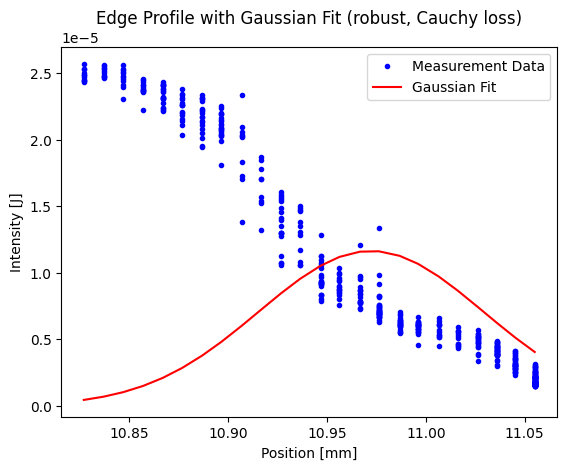

The FWHM is: 134.16344798171338 um


In [4]:
# Custom Cauchy loss function

def cauchy_loss(params, x, y, c):
    A, mu, sigma = params
    y_pred = A * np.exp(-(x - mu)**2 / (2 * sigma**2))
    residual = y - y_pred
    return np.log(1 + (residual / c)**2).sum()

# Function to define the Gaussian function for curve fitting
def gauss(params, x):
    A, mu, sigma = params
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

# Objective function for optimization
def objective(params, x, y, c):
    return cauchy_loss(params, x, y, c)
    


# Reading the measurement data from a CSV file
#filename = 'Babicz.csv'
filename = 'FWHM.csv'
#data = np.genfromtxt(filename, delimiter=',')
data = pd.read_csv(filename)

#x_data = data[:, 1]
#y_data = data[:, 0]
intensity = data.iloc[:, 0] #intensity
position = data.iloc[:, 1] #position
print(intensity)

#y_data = [1.7,1.7,1.7]
#x_data = [15.0,15.05,15.1,15.20]
#y_data = array.array('d', [1.7, 1.7, 1.7,1.7])
#x_data = array.array('d', [15.0,15.05,15.1])


# Initial guess for parameters
initial_guess = [0.01, np.mean(position), 0.06]
print("initial guess", initial_guess)

# Perform optimization
result = minimize(objective, initial_guess, args=(position, intensity, 1))

# Extract optimized parameters
popt = result.x
#print("popt", popt)

# Normalize
#pdf = gauss(popt,x_data)
#normalization_constant = np.trapz(pdf,x_data)
#print("normalization constant", normalization_constant)
#normalized_pdf = pdf/normalization_constant

# Calculating the full width at half maximum (FWHM)
FWHM = 2 * np.sqrt(2 * np.log(2)) * popt[2]

# Plotting the data and the fit
plt.plot(position, intensity, 'b.', label='Measurement Data')
plt.plot(position, gauss(popt, position), 'r-', label='Gaussian Fit')
plt.xlabel('Position [mm]')
plt.ylabel('Intensity [J]')
plt.title('Edge Profile with Gaussian Fit (robust, Cauchy loss)')
plt.legend()
plt.show()

print("The FWHM is:", FWHM*1000, "um")

In [20]:
from array import array

# Initializing the list
list = [1, 2, 3, 4, 5]

# Printing the list
print("The list is : " + str(list))

res = array("i", list)
print(res

The list is : [1, 2, 3, 4, 5]
array('i', [1, 2, 3, 4, 5])


In [24]:
import array as arr
a = arr.array('d', [1.1, 3.5, 4.5])
print(a)

array('d', [1.1, 3.5, 4.5])
